In [1]:
# load the package
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import os 

print(os.getcwd())
print(os.listdir())

# some customized settings for better visulization
plt.rcParams["figure.figsize"] = (12, 12)
plt.rcParams["figure.dpi"] = 300

/mnt/bioSSD/Demo_Esophagus
['original', '.DS_Store', '._.DS_Store', '.git', '.gitignore', 'SRA', '.ipynb_checkpoints', 'ESC1_post_QC.h5ad', 'ESC1_QC.ipynb', 'ESC2_post_QC.h5ad', 'ESC2_QC.ipynb', 'ESC3_post_QC.h5ad', 'ESC3_QC.ipynb', 'Data_Integration.ipynb', '._Data_Integration.ipynb', '3_sample_major_celltype_annotation.h5ad', 'T_NK_annotation.ipynb', '3_sample_T_NK_secondary_annotation.h5ad']


In [2]:
# load post-QC data
adata_ESC1=sc.read_h5ad('ESC1_post_QC.h5ad')
adata_ESC2=sc.read_h5ad('ESC2_post_QC.h5ad')
adata_ESC3=sc.read_h5ad('ESC3_post_QC.h5ad')
print(adata_ESC1);print(adata_ESC2);print(adata_ESC3)
# we add a sample prefix to cell barcode to avoid confusion
adata_ESC1.obs_names=["ESC1_" + x for x in adata_ESC1.obs_names]
adata_ESC2.obs_names=["ESC2_" + x for x in adata_ESC2.obs_names]
adata_ESC3.obs_names=["ESC3_" + x for x in adata_ESC3.obs_names]

AnnData object with n_obs × n_vars = 4094 × 27984
    obs: 'sample', 'response', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'
AnnData object with n_obs × n_vars = 3282 × 27984
    obs: 'sample', 'response', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'mt', 

In [3]:
# merge the data into 1 large adata object fot further analysis
adata=ad.concat([adata_ESC1,adata_ESC2,adata_ESC3])
print(adata.obs['sample'].value_counts())

# we remove genes that are rarely expressed in cells
sc.pp.filter_genes(adata,min_cells=50)
print(adata)

sample
ESC3    4735
ESC1    4094
ESC2    3282
Name: count, dtype: int64
AnnData object with n_obs × n_vars = 12111 × 15199
    obs: 'sample', 'response', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'n_cells'


In [4]:
# We've learnt that there's significant batch effect among these 3 samples previously,
# so we will perform harmony batch effect correction for meaningful biological interpretations.
# Harmony batch correction is based on Principle Compoment(PC), the result of Principle Component Analysis(PCA).
# Therefore, we need to perform PCA first.
adata.layers["counts"]=adata.X.copy()
sc.pp.normalize_total(adata,target_sum=np.median(adata.obs["total_counts"]))
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=3000,subset=False)
print(adata)

AnnData object with n_obs × n_vars = 12111 × 15199
    obs: 'sample', 'response', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'


In [5]:
# Before data scaling, we want to remove several confusion factor of this process
# In this code, we remove the effect of cell cycling genes and ribosomal gene percentage
# The genes we present here are from Seurat, the R-based single-cell data analysis package
s_genes = [
    "MCM5", "PCNA", "TYMS", "FEN1", "MCM2", "MCM4", "RRM1",
    "UNG", "GINS2", "MCM6", "CDCA7", "DTL", "PRIM1", "UHRF1",
    "HELLS", "RFC2", "RPA2", "NASP", "RAD51AP1", "GMNN", "WDR76",
    "SLBP", "CCNE2", "UBR7", "POLD3", "MSH2", "ATAD2", "RAD51",
    "RRM2", "CDC45", "CDC6", "EXO1", "TIPIN", "DSCC1", "BLM",
    "CASP8AP2", "USP1", "CLSPN", "POLA1", "CHAF1B", "BRIP1", "E2F8"
]
g2m_genes = [
    "HMGB2", "CDK1", "NUSAP1", "UBE2C", "BIRC5", "TPX2", "TOP2A", "NDC80",
    "CKS2", "NUF2", "CKS1B", "MKI67", "TMPO", "CENPF", "TACC3", "SMC4",
    "CCNB2", "CKAP2L", "CKAP2", "AURKB", "BUB1", "KIF11", "ANP32E", "TUBB4B",
    "GTSE1", "KIF20B", "HJURP", "CDCA3", "CDC20", "TTK", "CDC25C", "KIF2C",
    "RANGAP1", "NCAPD2", "DLGAP5", "CDCA2", "CDCA8", "ECT2", "KIF23", "HMMR",
    "AURKA", "PSRC1", "ANLN", "LBR", "CKAP5", "CENPE", "CTCF", "NEK2",
    "G2E3", "GAS2L3", "CBX5", "CENPA"
]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
print(adata)
sc.pp.regress_out(adata,['pct_counts_ribo','S_score', 'G2M_score'])
# Now we can perform data scaling with confidence
sc.pp.scale(adata,max_value=10)

AnnData object with n_obs × n_vars = 12111 × 15199
    obs: 'sample', 'response', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'


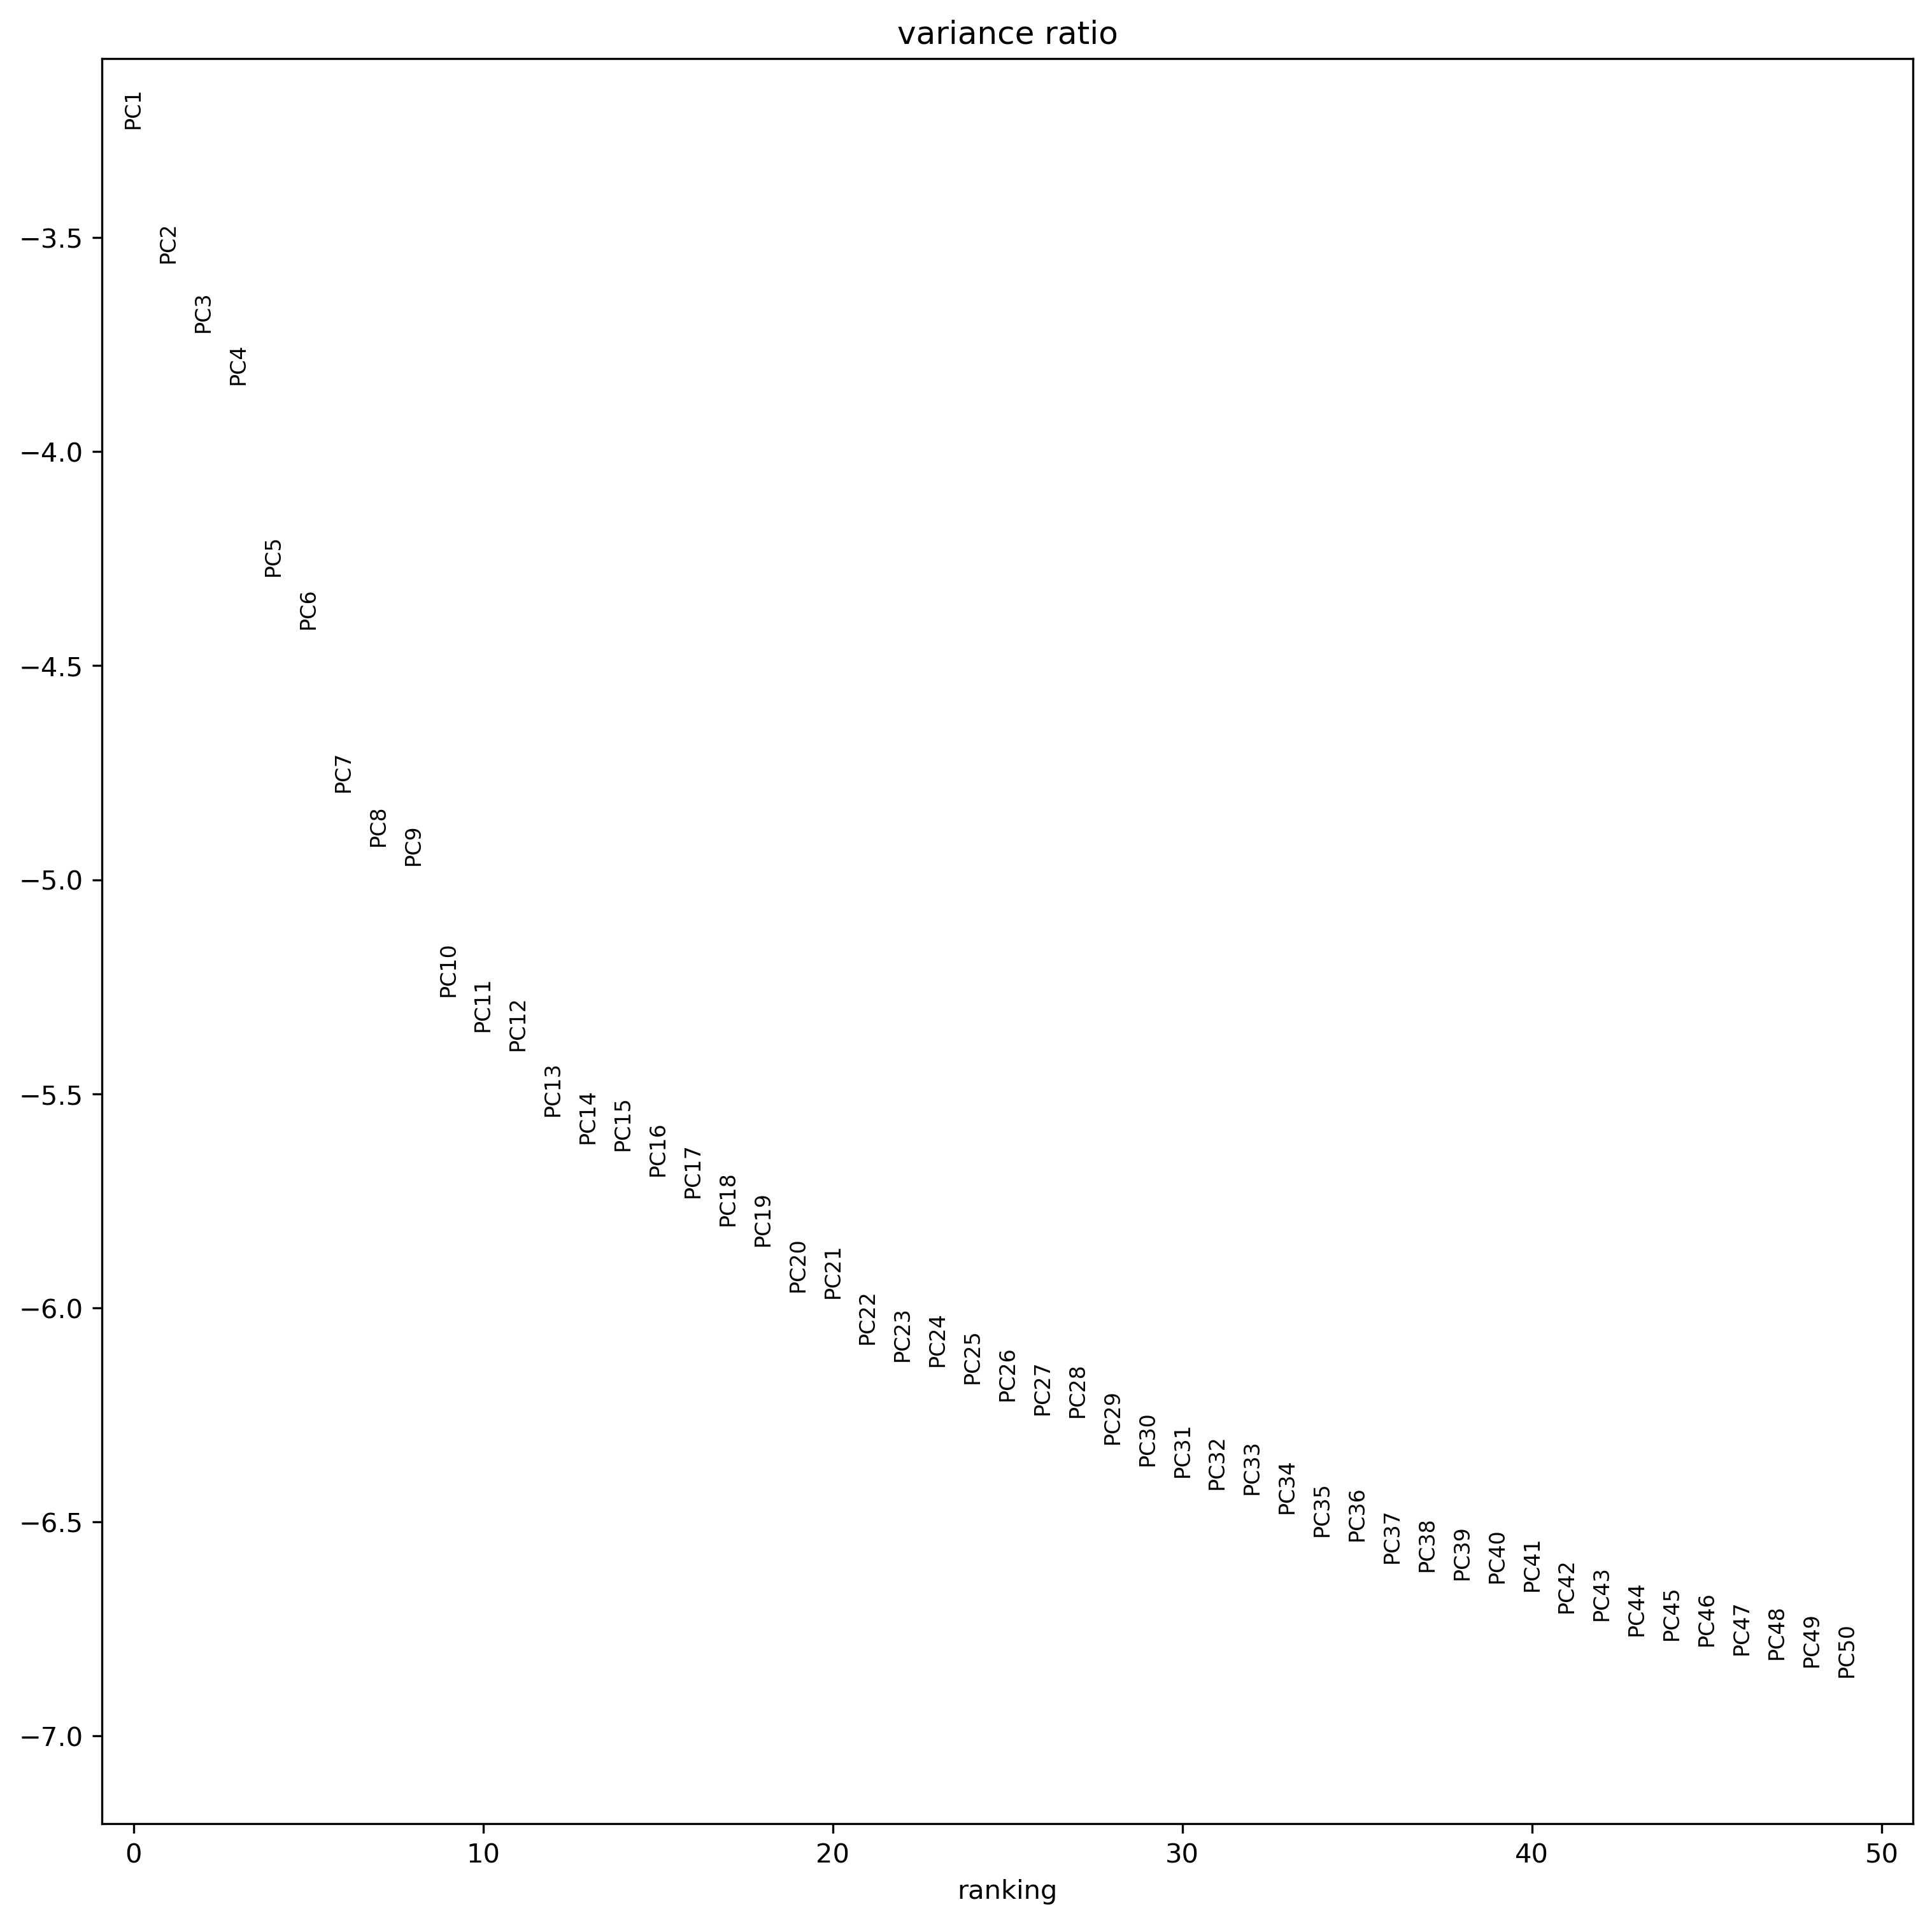

2025-11-13 12:06:57,602 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-13 12:06:58,145 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-13 12:06:58,163 - harmonypy - INFO - Iteration 1 of 10
2025-11-13 12:06:59,074 - harmonypy - INFO - Iteration 2 of 10
2025-11-13 12:07:00,026 - harmonypy - INFO - Iteration 3 of 10
2025-11-13 12:07:00,937 - harmonypy - INFO - Iteration 4 of 10
2025-11-13 12:07:01,866 - harmonypy - INFO - Iteration 5 of 10
2025-11-13 12:07:02,774 - harmonypy - INFO - Converged after 5 iterations


AnnData object with n_obs × n_vars = 12111 × 15199
    obs: 'sample', 'response', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'counts'


In [6]:
# Before batch correction, we should draw an Elbow Plot to decide 
# how many PCs should be inclused for further dimentionality reduction
# We do this before harmony batch correction because harmony alters PCA results
# making it hard to determine after harmony.
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata,log=True,n_pcs=50)
# In this case, we choose the first 8 PCs
sc.external.pp.harmony_integrate(adata,key="sample")
print(adata)

In [7]:
# Now we perform further dimentionality reduction and 
# unsupervised clustering based on harmony-corrected PCs
sc.pp.neighbors(adata,n_pcs=8,use_rep="X_pca_harmony")
sc.tl.umap(adata)

AnnData object with n_obs × n_vars = 12111 × 15199
    obs: 'sample', 'response', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


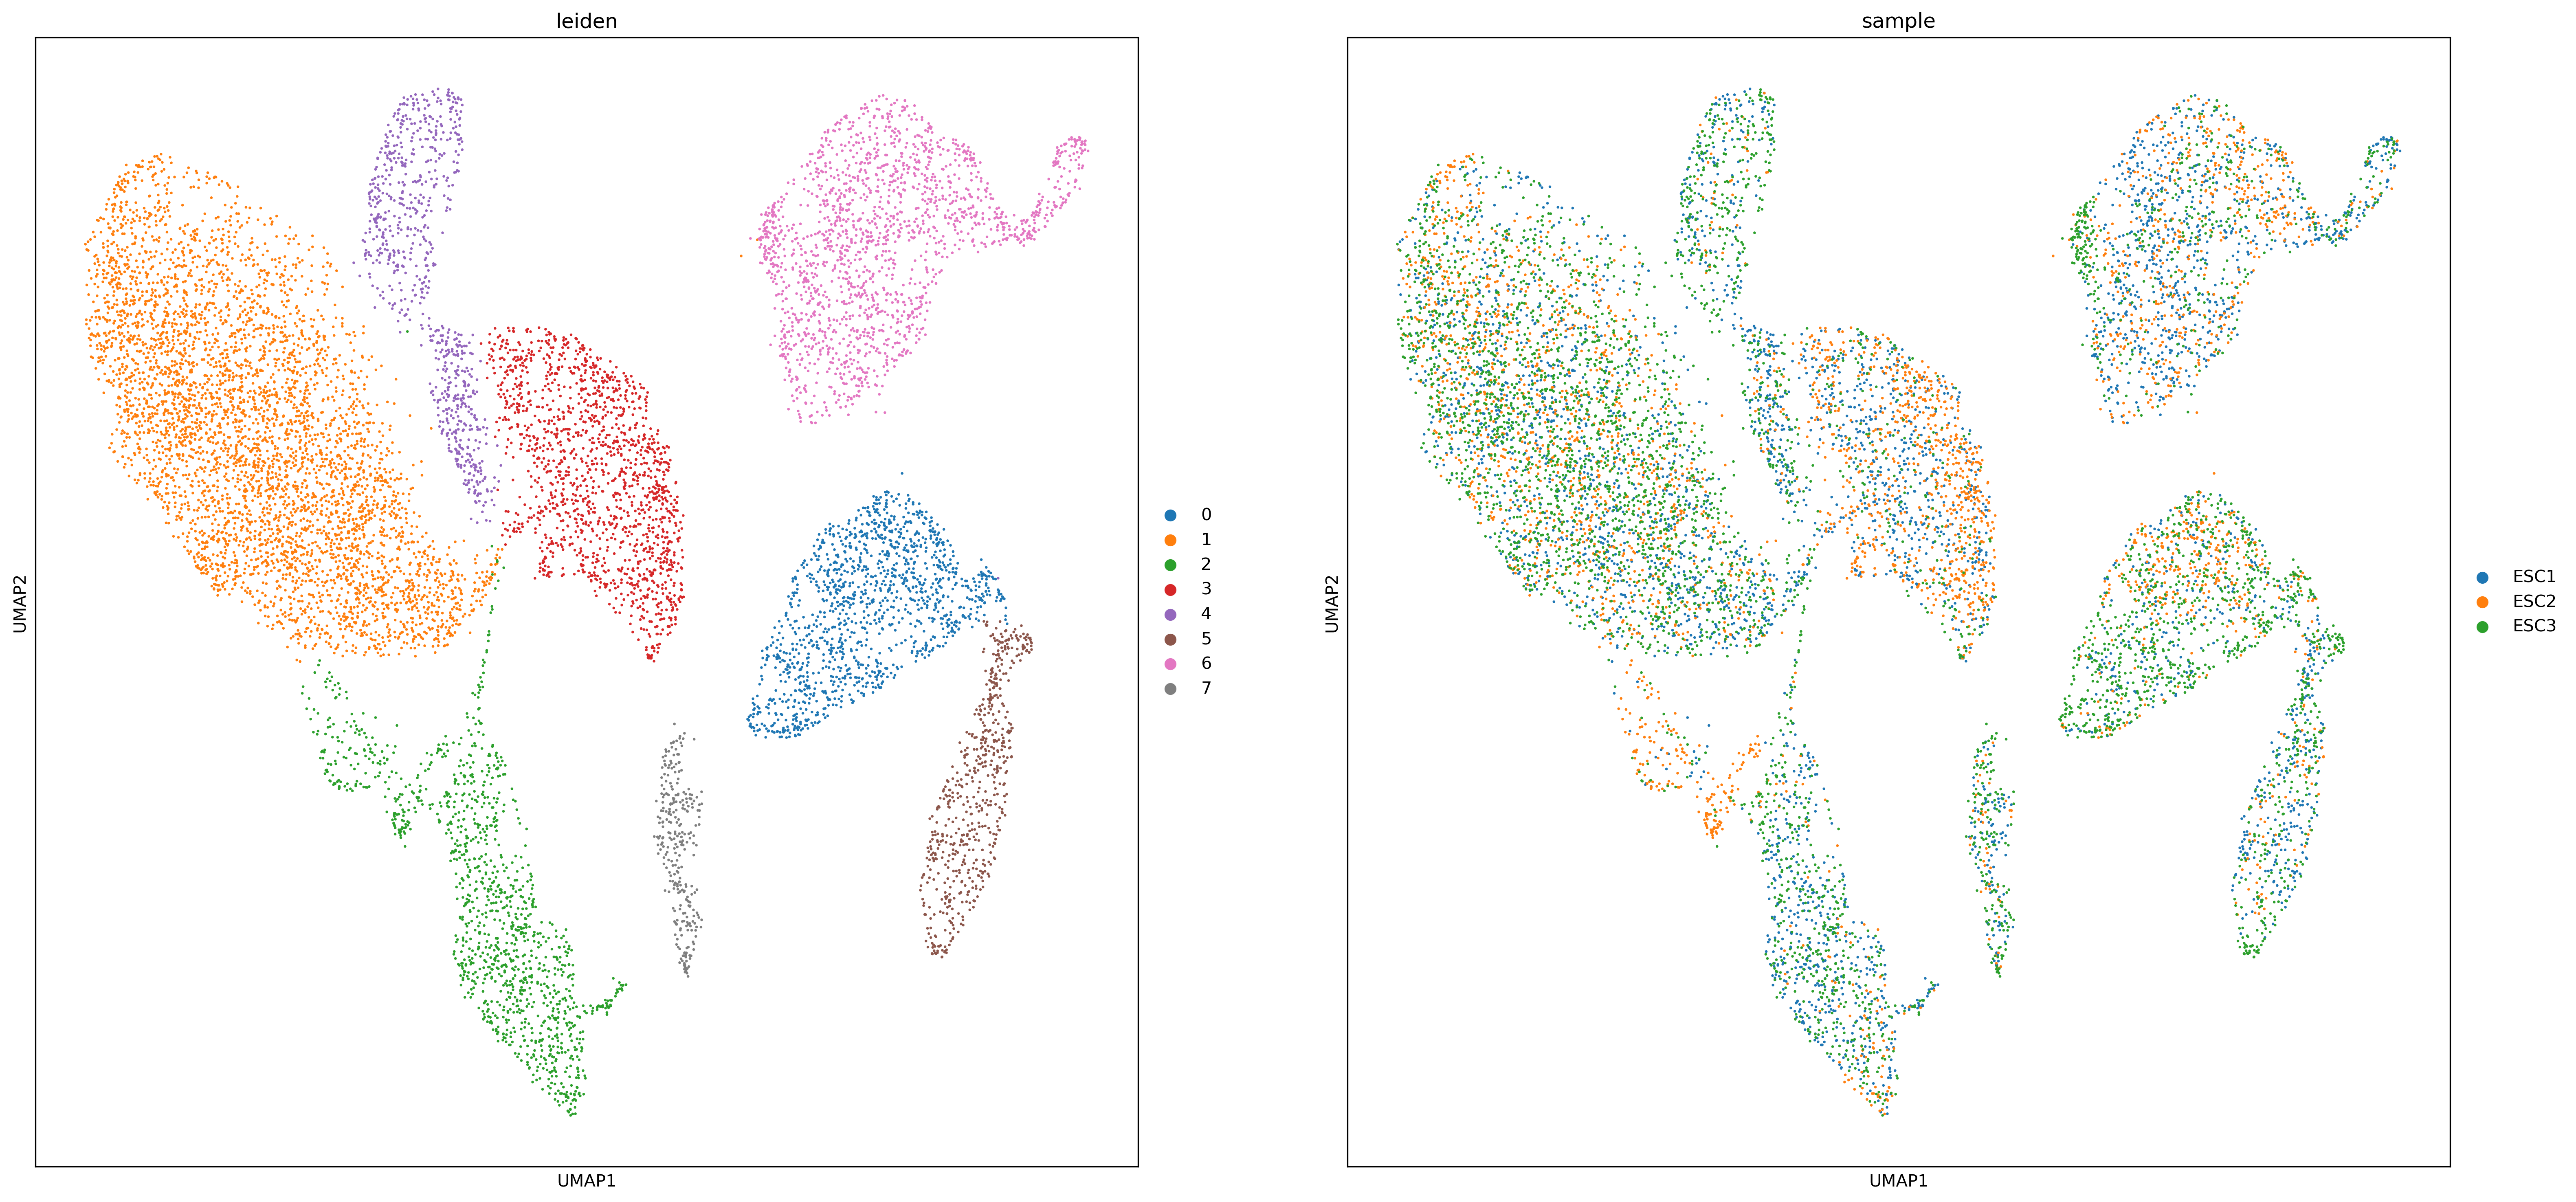

In [8]:
# We add a special cell for unsupervised clustering alone
# because this step is repeated many times until an ideal result is obtained
sc.tl.leiden(adata,resolution=0.15,flavor="igraph",n_iterations=2)
print(adata)
adata.obs["leiden"].value_counts()
sc.pl.umap(adata, color=["leiden", "sample"])

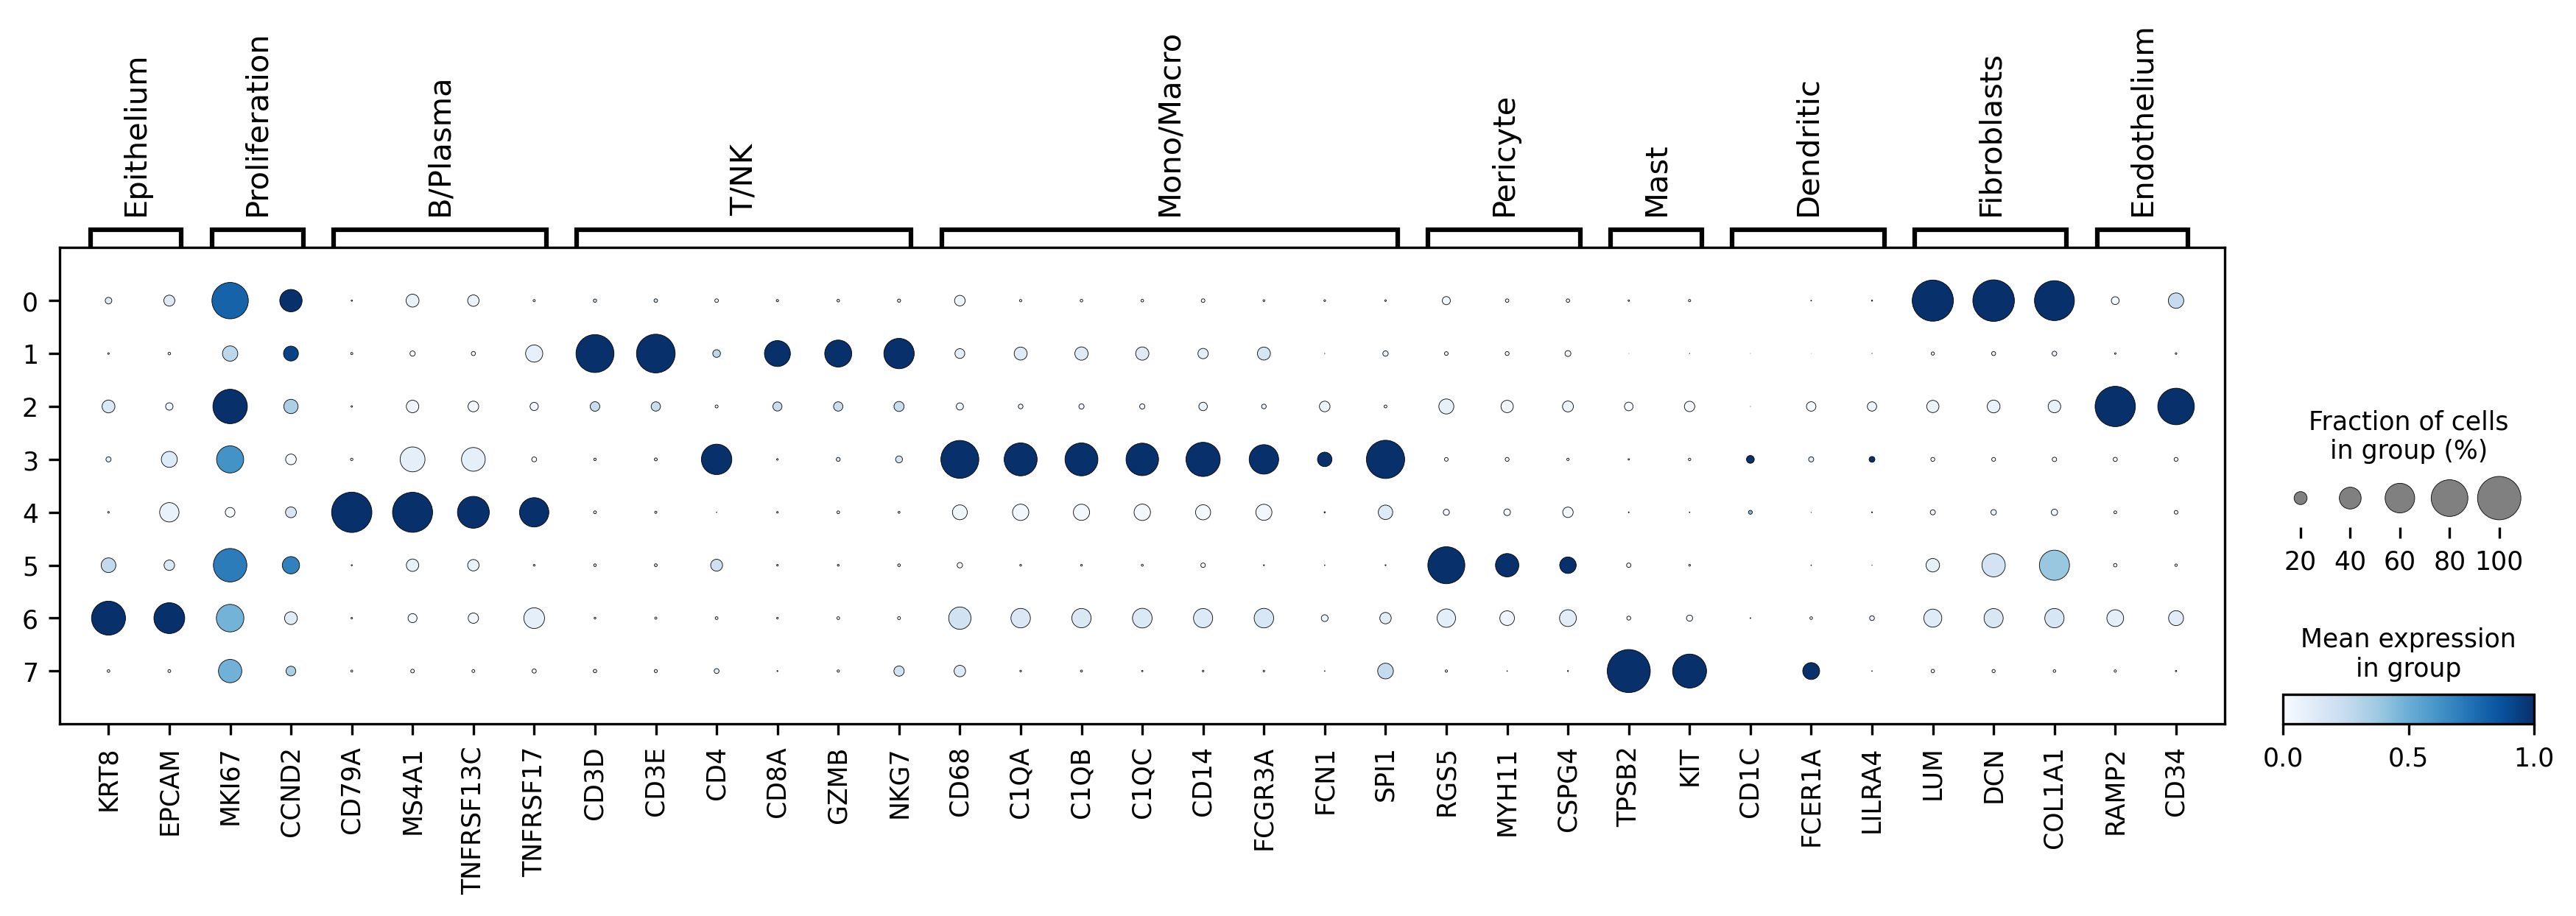

In [9]:
# Now we perform cell-type annotation based on marker genes
# We draw a dotplot for clear visulization
marker_genes = {
    "Epithelium": ["KRT8","EPCAM"], # "KRT5",
    "Proliferation": ["MKI67","CCND2"],
    "B/Plasma": ["CD79A", "MS4A1", "TNFRSF13C", "TNFRSF17"],
    "T/NK": ["CD3D", "CD3E", "CD4", "CD8A", "GZMB", "NKG7"],
    "Mono/Macro": ["CD68", "C1QA", "C1QB", "C1QC", "CD14", "FCGR3A", "FCN1", "SPI1"],
    "Pericyte": ["RGS5", "MYH11","CSPG4"],
    "Mast": ["TPSB2", "KIT"],
    "Dendritic": ["CD1C", "FCER1A", "LILRA4"], # "CLEC9A"
    "Fibroblasts": ["LUM", "DCN","COL1A1"],
    "Endothelium": ["RAMP2", "CD34"]}

sc.pl.dotplot(adata, 
              marker_genes,
              groupby="leiden", 
              standard_scale="var",
              cmap='Blues'
             )

In [10]:
# Now we perform celltype annotation 
cluster_ids = sorted(adata.obs['leiden'].unique().tolist())
cluster_ids = [str(c) for c in cluster_ids]  # 转成字符串

# We create a dataframe first
celltype = pd.DataFrame({
    'ClusterID': cluster_ids,
    'celltype': ['Unknown'] * len(cluster_ids)
})

# We put in celltype information here
celltype.loc[celltype['ClusterID'].isin(['0']), 'celltype'] = 'Fibroblast'
celltype.loc[celltype['ClusterID'].isin(['1']), 'celltype'] = 'T/NK'
celltype.loc[celltype['ClusterID'].isin(['2']), 'celltype'] = 'Endothelium'
celltype.loc[celltype['ClusterID'].isin(['3']), 'celltype'] = 'Mono/Macro'
celltype.loc[celltype['ClusterID'].isin(['4']), 'celltype'] = 'B/Plasma'
celltype.loc[celltype['ClusterID'].isin(['5']), 'celltype'] = 'Pericyte'
celltype.loc[celltype['ClusterID'].isin(['6']), 'celltype'] = 'Epithelium'
celltype.loc[celltype['ClusterID'].isin(['7']), 'celltype'] = 'Mast'

# Now we map the information back
adata.obs['leiden_str'] = adata.obs['leiden'].astype(str) # safety check
mapping = dict(zip(celltype['ClusterID'], celltype['celltype']))
adata.obs['celltype'] = adata.obs['leiden_str'].map(mapping)

print(adata.obs['celltype'].value_counts())

celltype
T/NK           4527
Epithelium     1767
Mono/Macro     1496
Fibroblast     1335
Endothelium    1284
B/Plasma        795
Pericyte        612
Mast            295
Name: count, dtype: int64


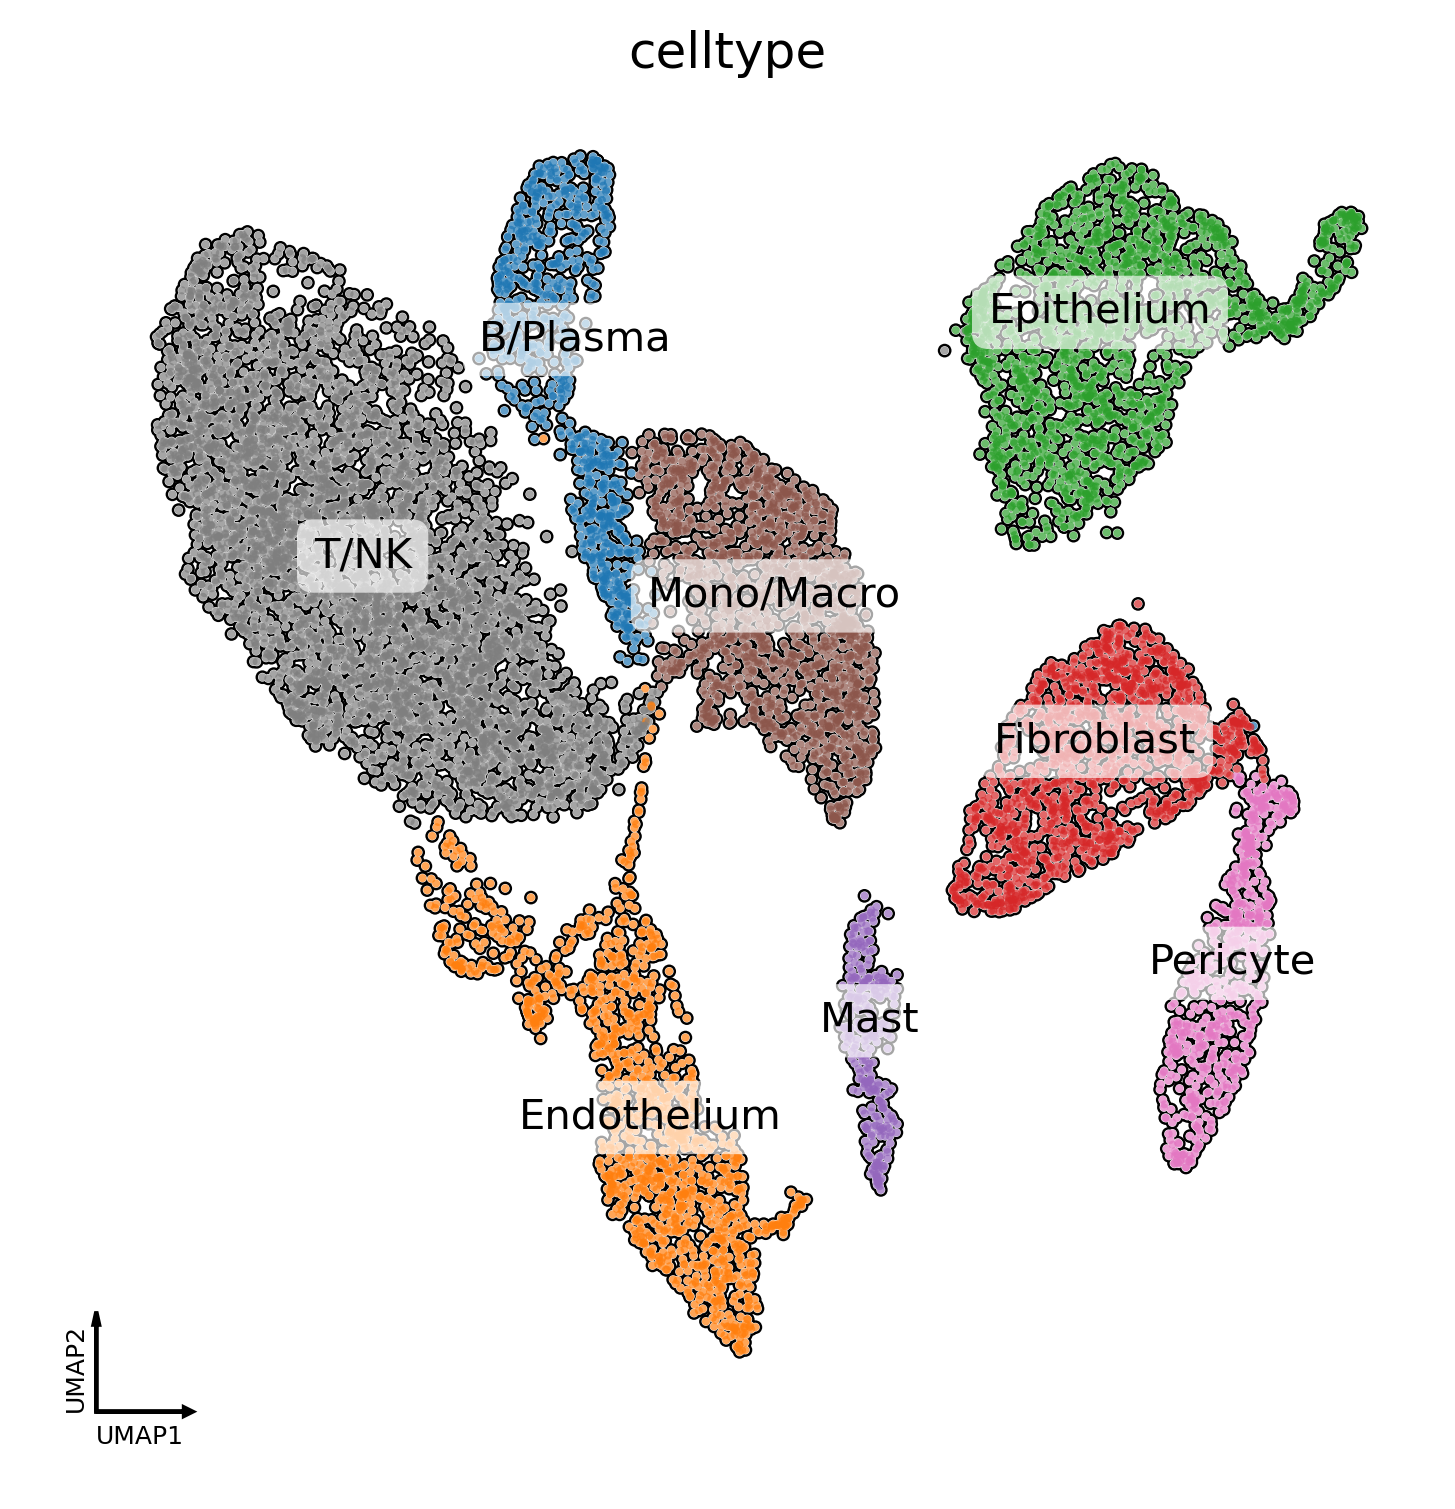

In [11]:
# Finally, we introduce a customized function to draw beautiful UMAP plot
from sklearn.neighbors import KernelDensity

def enhance_umap(adata, color='celltype', figsize=(6,6)):
    fig, ax = plt.subplots(figsize=figsize)
    sc.pl.umap(
        adata,
        color=color,
        legend_loc=None,
        frameon=False,
        size=15,
        ax=ax,
        add_outline=True,
        show=False
    )

    for cell_type in adata.obs[color].unique():
        mask = adata.obs[color] == cell_type
        x = adata.obsm["X_umap"][mask, 0]
        y = adata.obsm["X_umap"][mask, 1]

        x_min, x_max = x.min() - 0.5, x.max() + 0.5
        y_min, y_max = y.min() - 0.5, y.max() + 0.5
        xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]

        xy_train = np.vstack([x, y]).T
        xy_test = np.vstack([xx.ravel(), yy.ravel()]).T

        kde = KernelDensity(bandwidth=0.5, metric='euclidean')
        kde.fit(xy_train)

        Z = np.exp(kde.score_samples(xy_test))
        Z = Z.reshape(xx.shape)

    cell_type_counts = adata.obs[color].value_counts(normalize=True) * 100
    for cell_type, percentage in cell_type_counts.items():
        mask = adata.obs[color] == cell_type
        x = np.median(adata.obsm["X_umap"][mask, 0])
        y = np.median(adata.obsm["X_umap"][mask, 1])
        ax.text(
            x, y, f"{cell_type}",
            fontsize=10, 
            ha="center", 
            color="black",
            bbox=dict(
                facecolor='white',         
                edgecolor='none', 
                alpha=0.65,
                boxstyle="round,pad=0.4"  
            )  
        )
    ax = plt.gca()
    ax.set_xlabel('UMAP1', fontsize=6)
    ax.set_ylabel('UMAP2', fontsize=6)
 
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    x_range = x_max - x_min
    y_range = y_max - y_min
    aspect_ratio = (fig.get_size_inches()[0] / fig.get_size_inches()[1]) * (y_range / x_range)  # 校正宽高比

    dx = x_range * 0.1 * aspect_ratio
    dy = y_range * 0.1 * aspect_ratio  

    head_width = dy * 0.1
    head_length = dx * 0.1

    ax.arrow(
        x_min, y_min,
        dx, 0,
        head_width=head_width,
        head_length=head_length,
        fc='black',
        ec='black'
    )

    ax.arrow(
        x_min, y_min,
        0, dy,
        head_width=head_width,
        head_length=head_length,
        fc='black',
        ec='black'
    )

    label_offset = dx * 0.1
    ax.text(
        x_min + dx/2, 
        y_min - label_offset,  
        'UMAP1',
        ha='center', 
        va='top', 
        fontsize=6
    )
    ax.text(
        x_min - label_offset, 
        y_min + dy/2,
        'UMAP2',
        rotation=90,
        ha='right', 
        va='center',
        fontsize=6
    )

enhance_umap(adata, color='celltype', figsize=(6,6))

In [16]:
# Don't forget to save the data
adata.write_h5ad("3_sample_major_celltype_annotation.h5ad",compression="gzip")